In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.labelsize': 'large'
})

 # Absorbcija sevanja gama

Valovna dolžina sevanja gama je od 1 pm do 1 nm. To ustreza fotonom z energijo od nekaj keV do nekaj MeV. Ko sevanje prehaja skozi material, se absorbira. Številski pretok z globino pada kot

$$\phi = \phi_0 e^{\mu d},$$

pri čemer je $\mu$ koeficient absorpcije za snov. Število razpadov sledi Poissonovi porazdelitvi. Verjetnost $N$ razpadov je

$$p_N = \frac{\overline{N}^N}{N!} e^{\overline{N}},$$

pri čemer je standardni odmik od povprečja $\sigma = \sqrt{\overline{N}}$. Ker relativno število razpadov določa verjetnost razpada $\lambda$, pričakujemo eksponentno upadanje števila delcev $N$ s časom.

## Namen

Preveriti, da je standarni odmik pri Poissonovi porazdelitvi res $\sqrt{\overline{N}}$. Izmeriti dolžino, pri kateri svinec absorbira polovico delcev. Določiti porazdelitev časovnih intervalov med razpadi.

## Pribor

Geigerjev števec, vmesnik, radioaktivni preparat, svinčene ploščice.

## Meritve

Prvo kot test izmerimo sevanje na eni in drugi strani. V 2 minutah namerimo 1025 sunkov na strani z nalepko in 1278 sunkov na strani brez nalepke. Iz tega sklepamo, da je stran z nalepko res tista, ki seva le gama sevanje.

Zdaj 10-krat izmerimo aktivnost po eno minuto

In [2]:
poiss_N = np.array([
    621, 580, 549, 549, 608, 588, 580, 578, 608, 583
])

Pomerimo tudi debeline svinčenih plošč. Z kljunastim merilom debelino izmerimo v vrstnem redu, v katerem bomo plošče kasneje dodajali; na mestu, kjer bo curek prebijal ploščo.

In [3]:
d = 1e-3 * np.array([
    2.10, 1.60, 1.65, 1.65
])

Nato s ploščami sevanje merimo toliko časa, da dobimo zadostno število sunkov. Začnemo brez plošč, nato pa jih dodajamo v vrstnem redu, v katerem smo jim izmerili debelino.

In [4]:
absorp_t = 60 * np.array([
    2, 2, 2, 2, 3
])
absorp_N = np.array([
    454, 359, 341, 328, 434
])

Izmerimo še sevanje ozadja. Tokrat merimo 10 minut.

In [5]:
back_t, back_N = 60 * 10, 120

Na koncu vzorčenje nastavimo na najvišjo hitrost — tako da je med posameznimi sunki več vzorcev.

In [6]:
from pandas import read_csv

intervals_t, intervals_state = read_csv('1-intervali-med-sunki.csv').to_numpy().T

## Račun

Pri vseh meritvah, ki smo jih izvedli, je prisotno sevanje ozadja.

In [7]:
ϕ_back = back_N / back_t
ϕ_back

0.2

To vrednost bomo v nadaljevanju odšteli 

### Standarni odmik

Izračunamo povprečje $\overline N$ in nato še standardni odmik meritev.

In [8]:
np.sqrt(np.mean(poiss_N)), np.std(poiss_N)

(24.17436658942691, 22.481992794234234)

Povprečje je 24.2, standarni odmik pa 22.5. Vrednosti sta kar blizu — razliko verjetno lahko pripišemo temu, da je število meritev precej majhno.

### Absorpcija

Izračunamo skupne debeline in toke delcev.

In [9]:
d_cum = np.cumsum(np.insert(d, 0, 0))
ϕ = absorp_N / absorp_t
ϕ_0 = ϕ[0]

Imamo meritev $\phi_0$. Če torej logaritmiramo $\frac{\phi}{\phi_0}$, dobimo v odvisnosti od debeline $d$ premico

$$\ln\left( \frac{\phi}{\phi_0} \right) =  -\mu d,$$

katere naklon je $\mu$, absorpcijski koeficient za svinec.

In [10]:
absorp_par, absorp_cov = np.polyfit(d_cum, np.log(ϕ / ϕ_0), 1, cov=True)
μ, σ_μ = -absorp_par[0], np.sqrt(absorp_cov[0,0])
μ, σ_μ

(58.255185932459824, 9.567510411180367)

Prileganje si ogledamo še grafično. Meritev je precej malo, tako da nekolikoVidimo, da je meritev v logaritmični ska

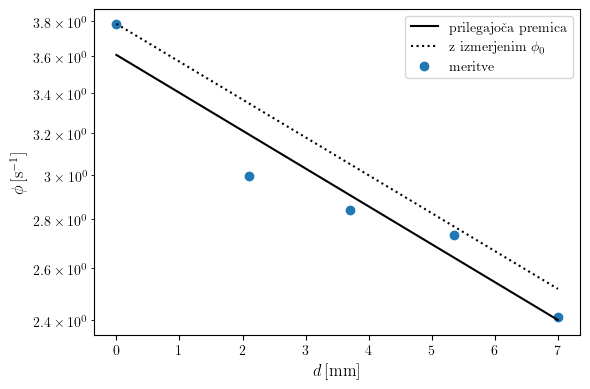

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])

ax.scatter(1e3 * d_cum, ϕ, label='meritve', color='tab:blue')
ax.plot(1e3 * d_cum, ϕ_0 * np.exp(-μ*d_cum + absorp_par[1]), label='prilegajoča premica', color='black')
ax.plot(1e3 * d_cum, ϕ_0 * np.exp(-μ*d_cum), label='z izmerjenim $\phi_0$', color='black', linestyle=':')

ax.set_yscale('log')
ax.set_xlabel(r'$d\,[\mathrm{mm}]$')
ax.set_ylabel(r'$\phi\,[\mathrm{s^{-1}}]$')
ax.legend()
fig.tight_layout()

Neposredno iz tega koeficienta lahko zdaj poračunamo razpolovno debelino

$$d_{1/2} = \frac{\ln 2}{\mu}.$$

In [12]:
d_half = np.log(2) / μ
σ_d_half = np.log(2) / μ**2 * σ_μ
1e3 * d_half, 1e3 * σ_d_half

(11.89846310616139, 1.9541379505204466)

Razpolovna debelina svinca je torej

$$d_{1/2} = 12\,\mathrm{mm} \pm 2\,\mathrm{mm}.$$

### Časovni intervali med razpadi

Iz meritev v `1-intervali-med-sunki.csv` razberemo dolžine intervalov med zaznanimi razpadi. Ogledamo si njihovo porazdelitev.

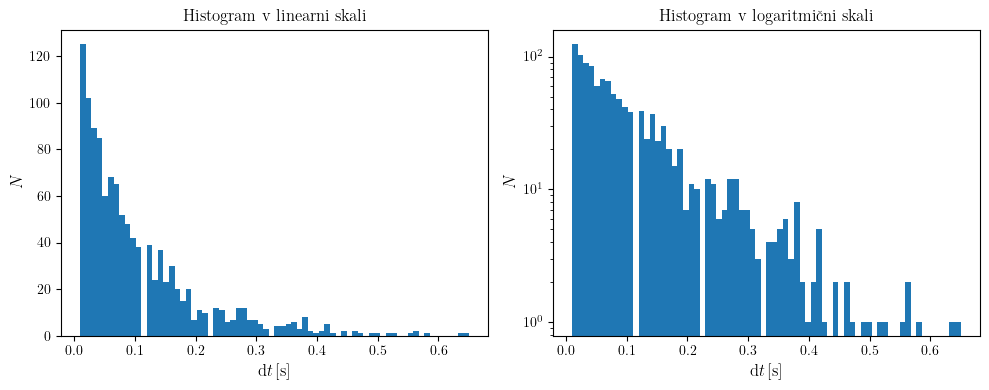

In [13]:
_ = np.flatnonzero(intervals_state) * (intervals_t[1] - intervals_t[0])
dt = _ - np.roll(_, 1)
dt[0] = _[0]

fig, axs = plt.subplots(1, 2, figsize=[10, 4])

axs[0].hist(dt, bins=70)
axs[1].hist(dt, bins=70)

axs[0].set_title('Histogram v linearni skali')
axs[0].set_xlabel(r'$\mathrm{d}t\,[\mathrm{s}]$')
axs[0].set_ylabel(r'$N$')
axs[1].set_yscale('log')
axs[1].set_title('Histogram v logaritmični skali')
axs[1].set_xlabel(r'$\mathrm{d}t\,[\mathrm{s}]$')
axs[1].set_ylabel(r'$N$')
fig.tight_layout()

Porazdelitev v logaritmični skali vsaj na prvi polovici močno spominja na premico. V drugi polovici je nekoliko bolj sporadična, a to je pričakovati, saj gre za redkejše dogodke (krajše intervale) in s tem manjši vzorec. S precej visoko gotovostjo lahko torej rečemo, da je porazdelitev diskretna oblika eksponentne.